In [1]:
using NPZ
using LinearAlgebra
using Statistics

In [2]:
xinputs = npzread("../emulator_files/xinputs.npz")["arr_0"]
yinputs = npzread("../emulator_files/yinputs.npz")["arr_0"]
hyper = npzread("../emulator_files/hypers.npz")["arr_0"]
alphas = npzread("../emulator_files/alphas.npz")["arr_0"]
k_arr = npzread("../emulator_files/k_arr.npz")["arr_0"];

In [3]:
param = [0.12, 0.022, 2.7, 1.0, 0.75];

In [4]:
function x_transformation(point, x_arr)
    """Pre-whiten the input parameters.

    Args:
        point (torch.tensor): the input parameters.

    Returns:
        torch.tensor: the pre-whitened parameters.
    """

    N, M = size(x_arr)
    cov_train = cov(x_arr)
    chol_train = cholesky(cov_train).U'
    mean_train = mean(x_arr, dims=1)
    # calculate the transformed training points
    transformed = inv(chol_train) * (point .- mean_train)'

    return transformed
end

function y_transformation(point, y_arr)
    """Transform the outputs.

    Args:
        yvalues (np.ndarray): the values to be transformed

    Returns:
        np.ndarray: the transformed outputs
    """
    ylog = log.(y_arr)
    ymean = mean(ylog, dims=1)
    ystd = std(ylog, dims=1)
    return ((point .- ymean) ./ ystd)'
end

function inv_y_transformation(point, y_arr)
    """Transform the outputs.

    Args:
        yvalues (np.ndarray): the values to be transformed

    Returns:
        np.ndarray: the transformed outputs
    """
    ylog = log.(y_arr)
    ystd = std(ylog, dims=1)
    ymean = mean(ylog, dims=1)
    return exp.(ystd .* preds' .+ ymean)
end

inv_y_transformation (generic function with 1 method)

In [5]:
xtrain = x_transformation(xinputs, xinputs)
ytrain = y_transformation(yinputs, yinputs)
param_t = x_transformation(param', xinputs);

In [6]:
function get_kernel(arr1, arr2, hyper)
    """Compute the kernel matrix between the sets of training cosmoligical parameters
       and the desired set of cosmological parameters.
    Args:
        x1 (np.ndarray): [N x d] tensor of points.
        x2 (np.ndarray): [M x d] tensor of points.
        hyper (np.ndarray): [d+1] tensor of hyperparameters.
    Returns:
        np.ndarray: a tensor of size [N x M] containing the kernel matrix.
    """
    
    arr1_w = @.(arr1/exp(hyper[2:6]))
    arr2_w = @.(arr2/exp(hyper[2:6]))
    
    # compute the pairwise distance
    term1 = sum(arr1_w.^2, dims=1)
    term2 = 2 * arr1_w' * arr2_w
    term3 = sum(arr2_w.^2, dims=1)'
    dist = term1 - term2' .+ term3

    # compute the kernel
    kernel = @.(exp(hyper[1]) * exp(-0.5 * dist))

    return kernel
end

get_kernel (generic function with 1 method)

In [7]:
preds = []
for i in 1:40
    kernel = get_kernel(xtrain, param_t, hyper[i, :])
    mean = dot(vec(kernel), vec(alphas[i,:]))
    push!(preds, mean)
end

In [8]:
Pk_emul = vec(inv_y_transformation(preds, yinputs));

In [4]:
using LimberJack
cosmo = Cosmology(0.252, 0.039, 0.75, 1.0, 0.72,
                  nk=500, tk_mode="EisHu")
Pk_EisHu = lin_Pk(cosmo, k_arr, 0.0);

┌ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
└ @ Base loading.jl:1423


In [6]:
cosmo = Cosmology(0.252, 0.039, 0.75, 1.0, 0.72,
                  nk=500, tk_mode="emulator")
Pk_emul_L = lin_Pk(cosmo, k_arr, 0.0);

LoadError: UndefVarError: emulator not defined

In [11]:
cosmo = Cosmology(0.252, 0.039, 0.75, 1.0, 0.72,
                  nk=500, tk_mode="emulator")

LoadError: UndefVarError: Cosmology not defined

In [12]:
ref = [1.05199810e+03, 1.39972787e+03, 1.86175310e+03, 2.47485290e+03,
       3.28678329e+03, 4.35879529e+03, 5.76807365e+03, 7.60883617e+03,
       9.99017257e+03, 1.30291073e+04, 1.68341153e+04, 2.14732641e+04,
       2.69244140e+04, 3.30028431e+04, 3.92692797e+04, 4.49267904e+04,
       4.87473257e+04, 4.91726610e+04, 4.49690394e+04, 3.67747863e+04,
       2.82780596e+04, 2.29757121e+04, 1.74933110e+04, 1.07923121e+04,
       7.73217085e+03, 4.73490310e+03, 2.81547163e+03, 1.63726622e+03,
       9.16888584e+02, 5.03788217e+02, 2.70399989e+02, 1.42297928e+02,
       7.35961443e+01, 3.74882941e+01, 1.88420637e+01, 9.35899651e+00,
       4.60024344e+00, 2.24010663e+00, 1.08184944e+00, 5.18425752e-01];

In [17]:
using Plots
#plot(k_arr, Pk_EisHu, xaxis=:log, yaxis=:log, label="EisHu")
plot!(k_arr, ref, xaxis=:log, yaxis=:log, label="ref")
plot!(k_arr, Pk_emul, xaxis=:log, yaxis=:log, label="Emulator")

┌ Warning: No strict ticks found
└ @ PlotUtils /home/jaime/.julia/packages/PlotUtils/jNTYY/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/jaime/.julia/packages/PlotUtils/jNTYY/src/ticks.jl:191


In [14]:
plot(k_arr, (Pk_EisHu-Pk_emul)./Pk_EisHu, xaxis=:log, label="(EisHu-Emul)/Emul")

LoadError: UndefVarError: Pk_EisHu not defined

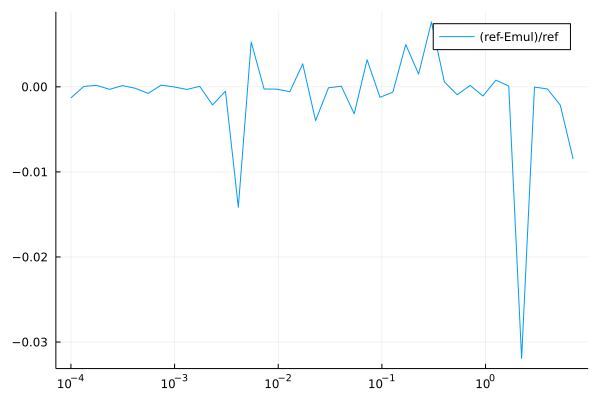

In [15]:
plot(k_arr, (ref-Pk_emul)./ref, xaxis=:log, label="(ref-Emul)/ref")

In [16]:
plot(k_arr, (ref-Pk_EisHu)./ref, xaxis=:log, label="(ref-EisHu)/ref")

LoadError: UndefVarError: Pk_EisHu not defined